## Load and train model 

In [1]:
import pandas as pd 
from datetime import datetime  
from load_DataSet_subway_15 import load_normalized_dataset
from DL_utilities import DictDataLoader,Trainer,PI_object,QuantileLoss,load_model,get_loss,choose_optimizer,get_dic_results
from PI import DeepEnsemble,plot_bands_CQR
from load_adj import load_adj
import numpy as np 
import os 
import sys
import torch
import torch.nn as nn
from torch.optim import SGD,Adam,AdamW
import random



try:
    from plotting import plot_loss
    import matplotlib.pyplot as plt 
except : 
    print('matplotlib.pyplot is not available')

notebook_dir = os.getcwd()
code_dir = os.path.abspath(os.path.join(notebook_dir, '../'))
if code_dir not in sys.path:
    sys.path.insert(0,code_dir)

# Import models : 
from dl_models.CNN_based_model import CNN
from dl_models.MTGNN import gtnet
from dl_models.RNN_based_model import RNN
from dl_models.STGCN import STGCNChebGraphConv, STGCNGraphConv
from dl_models.STGCN_utilities import calc_chebynet_gso,calc_gso

# Import config
from config import get_config,get_parameters

# Paths
folder_path = 'data/'
file_name = 'preprocessed_subway_15_min.csv'

#Init and load data: 
time_step_per_hour=4
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

train_prop = 0.6  #0.6
calib_prop = 0.4
valid_prop = 0.2  #0.2
window_pred = np.arange(2*96)

# Load subway in data:
subway_in = pd.read_csv(folder_path+file_name,index_col = 0)
subway_in.columns.name = 'Station'
subway_in.index = pd.to_datetime(subway_in.index)

# Invalid dates : 
invalid_dates = pd.date_range(datetime(2019,4,23,14),datetime(2019,4,28,14),freq = f'{60/time_step_per_hour}min')

# Load DataSet and Normalize it: 
(dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,train_prop,step_ahead,H,D,W,invalid_dates)


# Generate a dataloader object, which propose different validation (classic, K-fold Cross ...). 
# data_loader is a dictionnary containing train, valid, and test dataset
data_loader_obj = DictDataLoader(U,Utarget,train_prop,valid_prop,validation = 'classic', shuffle = True,calib_prop=calib_prop)

## Load and train model 

In [2]:
def load_train_calib_model(args):
    # load data model 
    data_loader_obj = DictDataLoader(U,Utarget,train_prop,valid_prop,validation = 'classic', shuffle = True, calib_prop=calib_prop)
    data_loader = data_loader_obj.get_dictdataloader(args.batch_size)

    # Quantile Loss
    quantiles = torch.Tensor([args.alpha/2,1-args.alpha/2]).to(args.device)
    assert args.out_dim == len(quantiles), "Output dimension doesn't match with the number of estimated quantiles"
    loss_function = get_loss(args.loss_function_type,quantiles)

    # Load model : 
    model = load_model(args)
    model.to(args.device)
    optimizer = choose_optimizer(model,args)

    trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
    trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
    Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type)  # calibration for PI 90%
      
    (preds,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])

    return(trainer,Q,preds,Y_true)

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.8min 


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


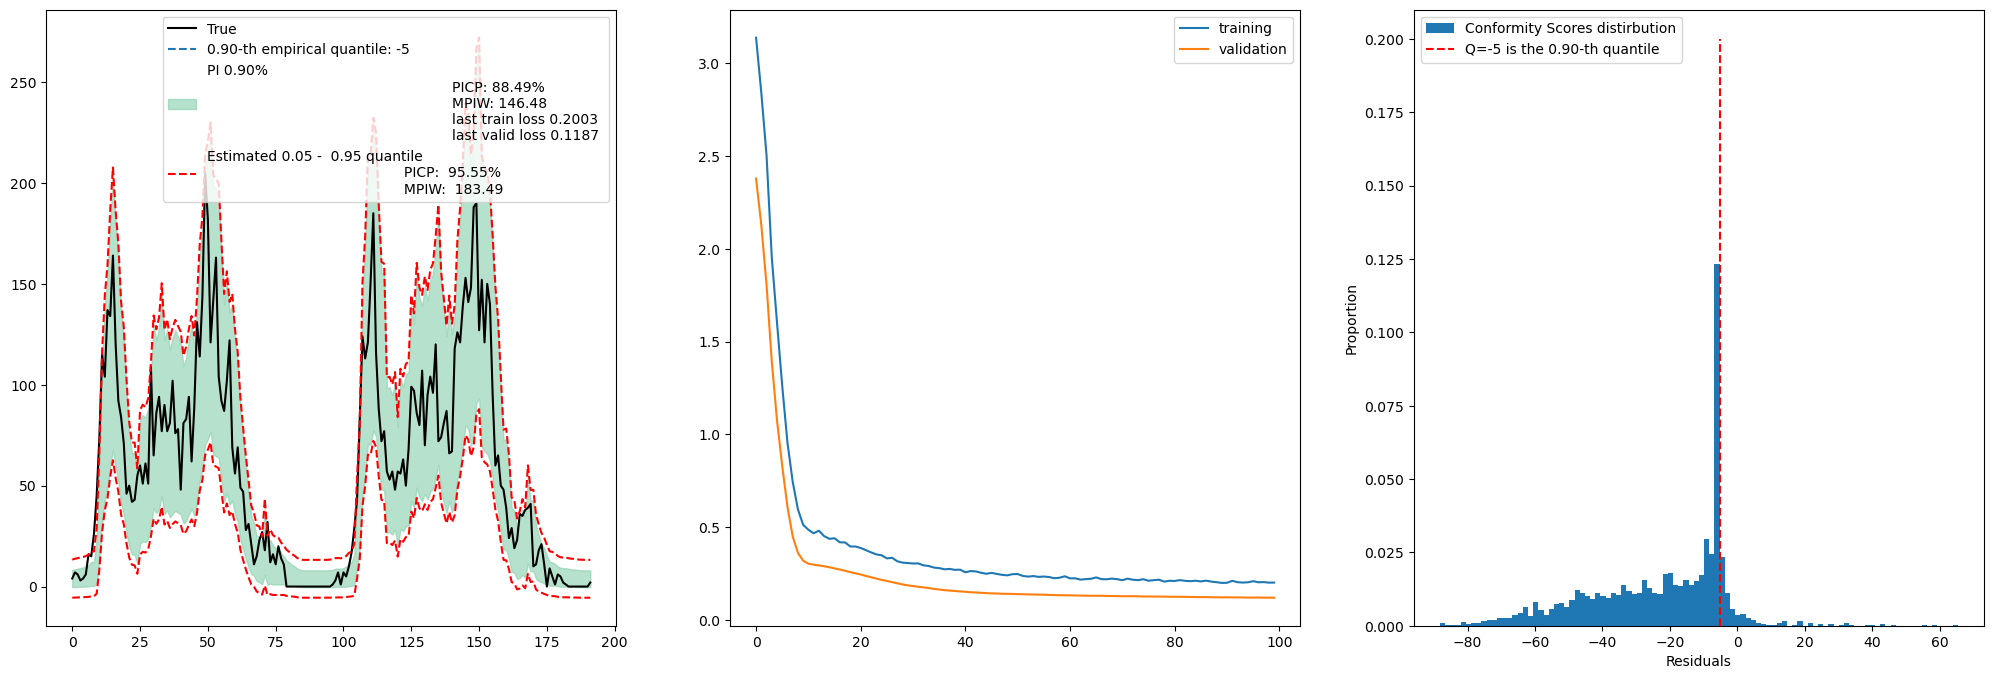

In [3]:
nb_trial = 1

for _ in range(nb_trial):
    config = get_config(model_name = 'CNN')

    config['conformity_scores_type'] = 'max_residual' 
    config['seq_length'] = L

    args = get_parameters(config)
    args.epochs = 100

    trainer,Q,preds,Y_true = load_train_calib_model(args)
    pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q)
    results = get_dic_results(trainer,pi)

    conformity_scores = trainer.conformity_scores[:,0,0]
    plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

180.93881225585938 0.955689063266307
143.93115234375 0.8975600784698382


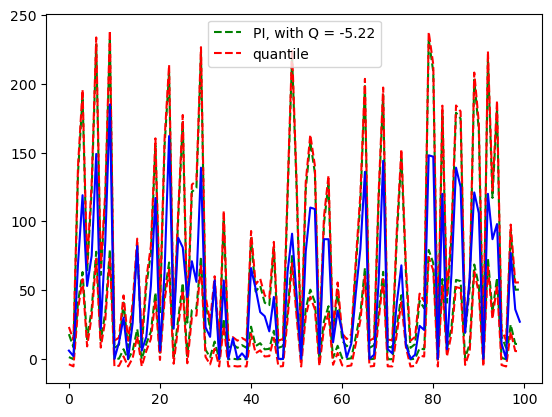

In [4]:
for training_mode in ['cal','train','validate','test']:
    print(training_mode)
    Pred_cal,Y_true_cal =trainer.test_prediction(allow_dropout = False,training_mode = 'cal')
    unorm_Pred_cal,unorm_Y_true_cal = dataset.unormalize_tensor(Pred_cal),dataset.unormalize_tensor(Y_true_cal)

    # PI 'classic' :
    pi_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, type_calib = 'classic')
    print(pi_cal.mpiw,pi_cal.picp)

    # PI 'CQR' : 
    pi_cqr_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, Q = Q, type_calib = 'CQR')
    print(pi_cqr_cal.mpiw,pi_cqr_cal.picp)

    plt.plot(np.arange(100),pi_cqr_cal.upper[:100,0,0],color = 'green',linestyle = 'dashed',label = f"PI, with Q = {'{:.2f}'.format(pi_cqr_cal.Q[0,0,0].item())}")
    plt.plot(np.arange(100),pi_cqr_cal.lower[:100,0,0],color = 'green',linestyle = 'dashed')
    plt.plot(np.arange(100),pi_cal.upper[:100,0,0],color = 'red',linestyle = 'dashed',label = 'quantile')
    plt.plot(np.arange(100),pi_cal.lower[:100,0,0],color = 'red',linestyle = 'dashed')
    plt.plot(np.arange(100),unorm_Y_true_cal[:100,0,0],color = 'blue')
    plt.legend()

In [14]:
# PI des quantiles est trop large (97%). Donc, Q devrait être négatif 
model = trainer.model
model.eval()
with torch.no_grad():
    data = [[x_b,y_b] for  x_b,y_b in trainer.dataloader['cal']]
    X_cal,Y_cal = torch.cat([x_b for [x_b,y_b] in data]),torch.cat([y_b for [x_b,y_b] in data])
    preds = model(X_cal) # x_cal is normalized

    # get lower and upper band
    if preds.size(-1) == 2:
        lower_q,upper_q = preds[...,0].unsqueeze(-1),preds[...,1].unsqueeze(-1)   # The Model return ^q_l and ^q_u associated to x_b

    elif preds.size(-1) == 1:
        lower_q,upper_q = preds,preds 
    else:
        raise ValueError(f"Shape of model's prediction: {preds.size()}. Last dimension should be 1 or 2.")
    
    # unormalized lower band, upper band, and Y_cal 
    lower_q, upper_q = dataset.unormalize_tensor(lower_q),dataset.unormalize_tensor(upper_q)
    Y_cal = dataset.unormalize_tensor(Y_cal)

    # Confority scores and quantiles
    if args.conformity_scores_type == 'max_residual':
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    if args.conformity_scores_type == 'max_residual_plus_middle':
        print("|!| Conformity scores computation is not based on 'max(ql-y, y-qu)'")
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) + ((lower_q>Y_cal)(upper_q<Y_cal))*(upper_q - lower_q)/2  # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function 

    quantile_order = torch.Tensor([np.ceil((1 - args.alpha)*(X_cal.size(0)+1))/X_cal.size(0)])
    Q = torch.quantile(conformity_scores, quantile_order, dim = 0) #interpolation = 'higher'

In [15]:
lower_q[:10,0,0],upper_q[:10,0,0],Y_cal[:10,0,0]

(tensor([ 27.0295,   2.3823, -10.6389, -11.9061, -11.9061,  -8.5437,  33.5009,
          41.8354,  46.4636, -12.4527]),
 tensor([177.8735,  67.0889,  53.7768,  37.4192,  37.4192,  36.1508, 213.2399,
         254.6087, 287.3973,  38.0547]),
 tensor([124.,  27.,  39.,   0.,   0.,  31., 109., 106., 121.,   4.]))

0.36081740260124207 0.9917475728155339


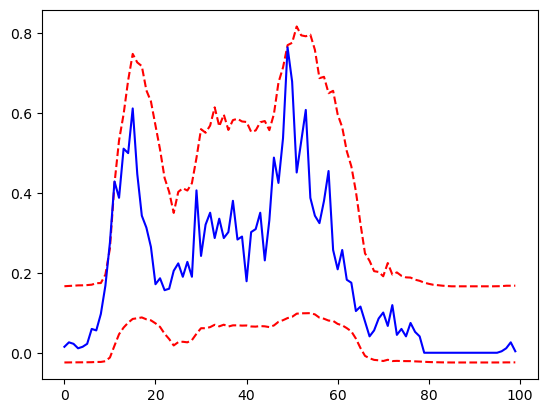

In [12]:
Pred_test,Y_true_test =trainer.test_prediction(allow_dropout = False,training_mode = 'test')
pi_test = PI_object(Pred_test,Y_true_test,alpha = args.alpha, type_calib = 'classic')
print(pi_test.mpiw,pi_test.picp)

plt.plot(np.arange(100),Pred_test[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_test[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_test[:100,0,0],color = 'blue')

0.34379279613494873 0.9918358340688438


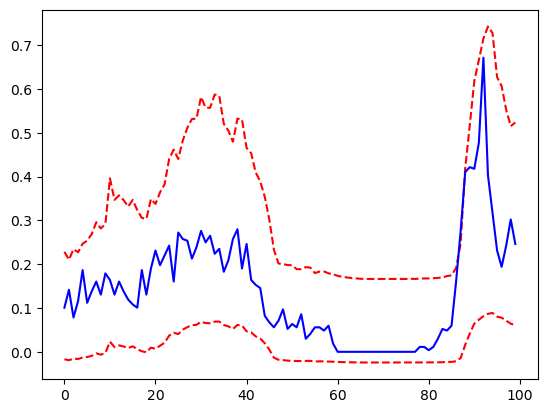

In [14]:
Pred_valid,Y_true_valid =trainer.test_prediction(allow_dropout = False,training_mode = 'validate')
pi_valid = PI_object(Pred_valid,Y_true_valid,alpha = args.alpha, type_calib = 'classic')
print(pi_valid.mpiw,pi_valid.picp)

plt.plot(np.arange(100),Pred_valid[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_valid[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_valid[:100,0,0],color = 'blue')

0.34810584783554077 0.9901325478645067


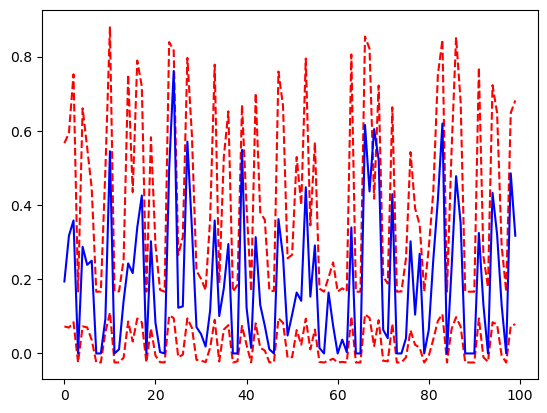

In [23]:
Pred_train,Y_true_train =trainer.test_prediction(allow_dropout = False,training_mode = 'train')
pi_train = PI_object(Pred_train,Y_true_train,alpha = args.alpha, type_calib = 'classic')
print(pi_train.mpiw,pi_train.picp)

plt.plot(np.arange(100),Pred_train[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_train[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_train[:100,0,0],color = 'blue')